**Dogs** **vs** **Cats** **Classification**



In [0]:
import zipfile
with zipfile.ZipFile('/content/drive/My Drive/dogs-vs-cats.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/My Drive/dogs_vs_cats')

In [0]:
import zipfile
with zipfile.ZipFile('/content/drive/My Drive/dogs_vs_cats/test1.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/My Drive/dogs_vs_cats/test1')

In [0]:
import zipfile
with zipfile.ZipFile('/content/drive/My Drive/dogs_vs_cats/train.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/My Drive/dogs_vs_cats/train')

In [0]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

In [2]:
TRAIN_DIR = '/content/drive/My Drive/dogs_vs_cats/train/train'
TEST_DIR = '/content/drive/My Drive/dogs_vs_cats/test1/test1'
IMG_SIZE = 50
LR = 1e-3
MODEL_NAME = 'dogs-vs-cats-convnet'

def create_label(image_name):
  # creat an one-hot encoded vector from image name
  word_label = image_name.split('.')[-3]
  if word_label == 'cat':
    return np.array([1,0])
  elif word_label == 'dog':
    return np.array([0,1])

def create_train_data():
  training_data = []
  for img in tqdm(os.listdir(TRAIN_DIR)):
    path = os.path.join(TRAIN_DIR, img)
    img_data = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img_data = cv2.resize(img_data, (IMG_SIZE, IMG_SIZE))
    training_data.append([np.array(img_data), create_label(img)])
  shuffle(training_data)
  np.save('train_data.npy', training_data)
  return training_data

def create_test_data():
  testing_data = []
  for img in tqdm(os.listdir(TEST_DIR)):
    path = os.path.join(TEST_DIR, img)
    img_num = img.split('.')[0]
    img_data = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img_data = cv2.resize(img_data, (IMG_SIZE, IMG_SIZE))
    testing_data.append([np.array(img_data), img_num])

  shuffle(testing_data)
  np.save('test_data.npy', testing_data)
  return testing_data

# if dataset is not created:
train_data = create_train_data()
test_data = create_test_data()
# if you. have already created the dataset:
# train_data = np.load('train_data.npy')
# test_data = np.load('test_data.npy')

100%|██████████| 12500/12500 [01:10<00:00, 177.03it/s]


In [0]:
train_data

In [0]:
train = train_data[:-500]
test = train_data[-500:]
X_train = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = [i[1] for i in train]
X_test = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test = [i[1] for i in test]

In [9]:
# Building the Model
tf.reset_default_graph()
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name = 'input')
convnet = conv_2d(convnet, 32, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 128, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 128, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 32, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)
convnet = fully_connected(convnet, 1024, activation = 'relu')
convnet = dropout(convnet, 0.8)
convnet = fully_connected(convnet, 2, activation = 'softmax')
convnet = regression(convnet, optimizer = 'adam', learning_rate = LR, loss = 'categorical_crossentropy')
model = tflearn.DNN(convnet, tensorboard_dir='log', tensorboard_verbose = 0)

model.fit(X_train, y_train, n_epoch=10, validation_set=(X_test, y_test), snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 3829  | total loss: 0.34626 | time: 90.437s
| Adam | epoch: 010 | loss: 0.34626 - acc: 0.8470 -- iter: 24448/24500
Training Step: 3830  | total loss: 0.34386 | time: 91.685s
| Adam | epoch: 010 | loss: 0.34386 - acc: 0.8452 | val_loss: 0.48251 - val_acc: 0.7900 -- iter: 24500/24500
--


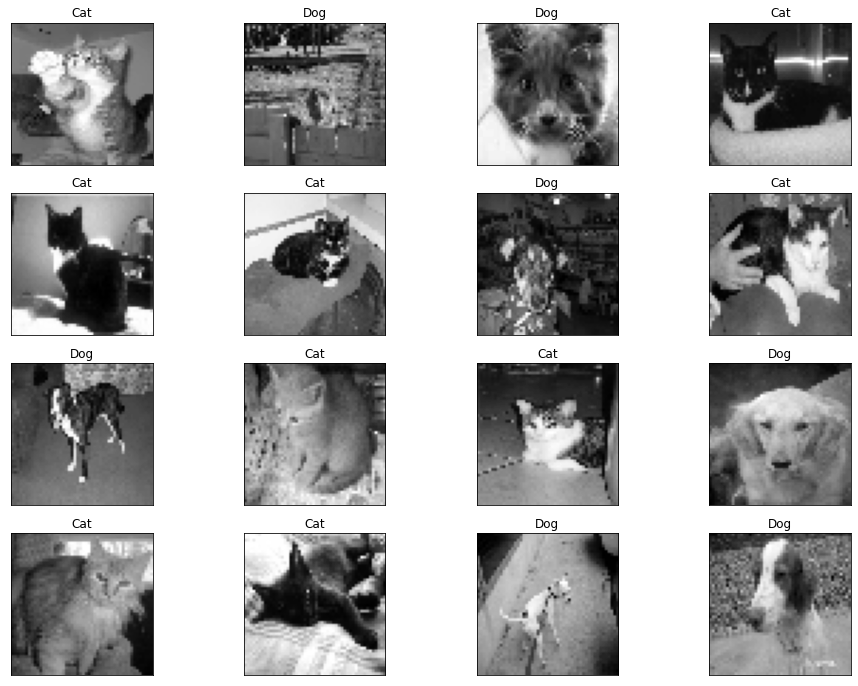

In [10]:
fig = plt.figure(figsize=(16, 12))

for num, data in enumerate(test_data[:16]):

  img_num = data[1]
  img_data = data[0]
  y = fig.add_subplot(4, 4, num+1)
  orig = img_data
  data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
  model_out = model.predict([data])[0]

  if np.argmax(model_out) == 1:
    str_label = 'Dog'
  else:
    str_label = 'Cat'

  y.imshow(orig, cmap='gray')
  plt.title(str_label)
  y.axes.get_xaxis().set_visible(False)
  y.axes.get_yaxis().set_visible(False)
plt.show()